## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

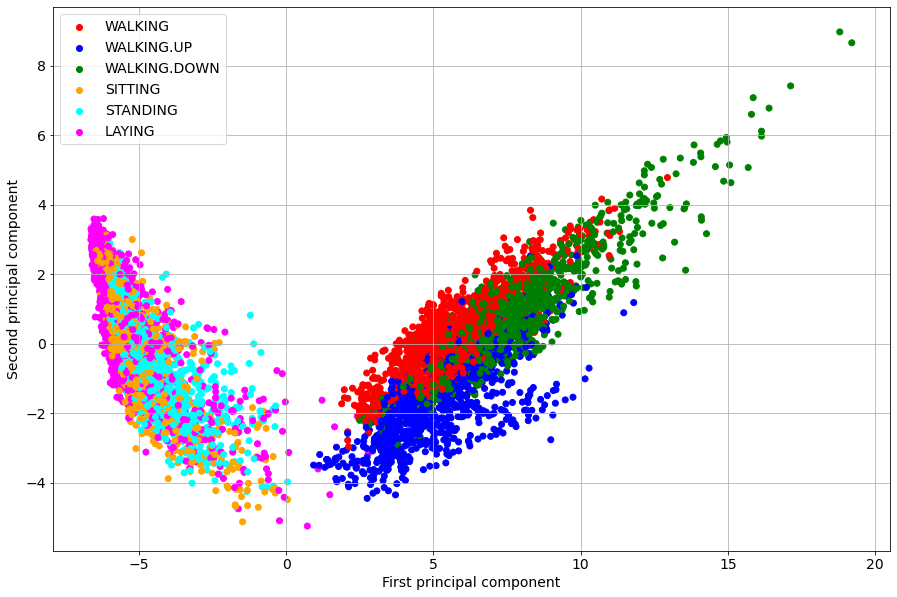

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [6]:
X_test.shape , X_train.shape

((2947, 128, 9), (7352, 128, 9))

In [7]:
BATCH_SIZE = 256

INPUT_SIZE = X_test.shape[1] * X_test.shape[2]

OUTPUT_SIZE = len(LABELS)

HIDDEN_SIZE = 64

N_LAYERS = n_hidden

N_EPOCHS = 10

DROPOUT = 0.25

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.data = []
        for number, target in enumerate(y_data):
            self.data.append([X_data[number], target])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X_data, y_data = self.data[idx]
        X_data = torch.tensor(X_data).reshape(-1)
        return X_data, torch.tensor(y_data)

In [9]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [10]:
X_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
X_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [11]:
class SimplyNeuralNetworkClassification(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, dropout):
        super().__init__()
        #self.embedding = nn.Embedding() #i think our not need embedding because data is representetion very informatifly
        self.linear_1 = nn.Linear(input_size, 400)
        self.relu_1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(400, 100)
        self.relu_2 = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(100)
        self.linear_3 = nn.Linear(100, output_size)
        #self.softmax = nn.Sigmoid()
        
    
    def forward(self, input):
        output = self.linear_1(input)
        output = self.relu_1(output)
        output = self.dropout(output)
        output = self.linear_2(output)
        output = self.batch_norm(output)
        output = self.relu_2(output)
        output = self.linear_3(output)
        #output = self.softmax(output)
        return output

In [12]:
model = SimplyNeuralNetworkClassification(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, N_LAYERS, DROPOUT)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [13]:
from torchmetrics import Accuracy

In [14]:
#training loop     out of a thousand pricks
writer = SummaryWriter()
global_step = 0
accuracy = Accuracy(task="multiclass", num_classes=OUTPUT_SIZE)
train_accuracy_epoch = []
train_loss_epoch = []

for epoch in trange(N_EPOCHS, desc="Epochs"):
    train_loss = []
    train_accuracy = []
    model.train(True)
    for X_batch, y_batch in tqdm(X_train_loader, desc="Train", leave=False):
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.squeeze(1)
        preds = model(X_batch)
        #preds = torch.tensor([pred.argmax().item() for pred in preds], dtype=torch.int64)

        loss = criterion(input = preds, target = y_batch.long())

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_accuracy.append(accuracy(preds, y_batch))
        train_loss.append(loss)

    train_accuracy_epoch.append(train_accuracy)
    train_loss_epoch.append(train_loss)


Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


In [15]:
train_accuracy_val = []
model.train(False)
for X_batch, y_batch in tqdm(X_test_loader, desc="Val", leave=False):
    y_batch = y_batch.squeeze(1)
    preds = model(X_batch)
    train_accuracy_val.append(accuracy(preds, y_batch))

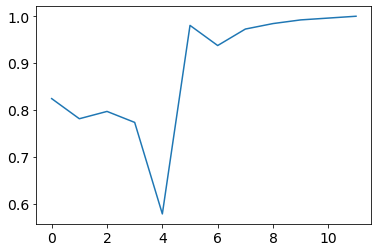

In [16]:
plt.plot(train_accuracy_val)
plt.title("Accuracy on validation dataset")

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [3]:
!pip3 install torchsummary


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [28]:
!pip3 freeze

aiogram==2.22.1
aiohttp==3.8.1
aiosignal==1.2.0
altgraph==0.17.3
appdirs==1.4.4
asttokens==2.2.1
async-timeout==4.0.2
attrs==21.4.0
audioread==2.1.9
Babel==2.9.1
backcall==0.2.0
certifi==2021.10.8
cffi==1.15.0
charset-normalizer==2.0.12
colorama==0.4.6
comm==0.1.3
cycler==0.11.0
dateparser==1.1.1
debugpy==1.6.7
decorator==5.1.1
distlib==0.3.6
docutils==0.19
executing==1.2.0
filelock==3.10.7
filetype==1.2.0
fonttools==4.34.4
frozenlist==1.3.0
future==0.18.2
idna==3.3
ipykernel==6.22.0
ipython==8.12.0
jedi==0.18.2
Jinja2==3.1.2
joblib==1.1.0
jupyter_client==8.2.0
jupyter_core==5.3.0
Kivy==2.1.0
kivy-deps.angle==0.3.3
kivy-deps.glew==0.3.1
kivy-deps.sdl2==0.4.5
Kivy-Garden==0.1.5
kiwisolver==1.4.3
librosa==0.9.1
llvmlite==0.38.0
MarkupSafe==2.1.2
matplotlib==3.5.2
matplotlib-inline==0.1.6
mpmath==1.3.0
multidict==6.0.2
nest-asyncio==1.5.6
networkx==3.1
numba==0.55.1
numpy==1.24.2
opencv-python==4.7.0.72
packaging==21.3
pandas==1.4.3
parso==0.8.3
pefile==2022.5.30
pickleshare==0.7.5
Pillow

In [2]:
!pip3 install tqdm


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import pandas as pd
from IPython.display import clear_output
from torchvision.models import AlexNet, AlexNet_Weights
from collections import defaultdict
from tqdm.auto import tqdm
import time
from torchmetrics import Accuracy, F1Score
from sklearn.metrics import f1_score, accuracy_score


import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


<h3>Let's look on data</h3>

In [4]:
numbers_dogs_different_breeds = np.zeros(50)
for i in range(50):
    count  = len(os.listdir(os.path.join(os.path.join(os.path.join(os.getcwd(), DATA_PATH), "train"), f'{i}')))
    numbers_dogs_different_breeds[i] = count

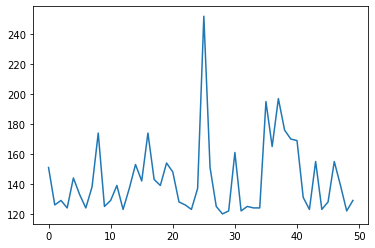

In [5]:
plt.plot(numbers_dogs_different_breeds)

In [6]:
print(f"mean count: {numbers_dogs_different_breeds.mean()}")
print(f"max count: {numbers_dogs_different_breeds.max()}")
print(f"min count: {numbers_dogs_different_breeds.min()}")

mean count: 143.32
max count: 252.0
min count: 120.0


<h3>Continue</h3>

In [3]:
#constant
DATA_PATH = "data_new/"

NUM_WORKERS = 4

SIZE_H = SIZE_W = 96 #размер к которому мы приводим фотки

NUM_CLASSES = 50

EPOCH_NUM = 30

BATCH_SIZE = 1024

image_mean = [0.485, 0.456, 0.406] 
image_std  = [0.229, 0.224, 0.225]

EMBEDDING_SIZE = 128

In [27]:
#prepare data(devide on Train and Test datasets)
os.mkdir(os.path.join(DATA_PATH, 'test_2'))

In [28]:
for i in range(NUM_CLASSES):
    os.mkdir(os.path.join(os.path.join(DATA_PATH, 'test_2'), f"{i}"))

In [22]:
# len(train) / len(test) = 85 / 15
for i in range(NUM_CLASSES):
    for j in range(int(numbers_dogs_different_breeds[i] * 0.15)):
        os.replace(os.path.join(os.path.join(os.path.join(DATA_PATH, 'train'), f"{i}"), f'{j}.jpeg'),
                   os.path.join(os.path.join(os.path.join(DATA_PATH, 'test_2'), f"{i}"), f'{j}.jpeg'))

In [7]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])

In [8]:
DATA_TRAIN_PATH = "data_new//train"
dataset = torchvision.datasets.ImageFolder(root=DATA_TRAIN_PATH, transform=transformer)

In [ ]:
#DATA_VAL_PATH = "data_new\\test_2"
#DATA_TEST_PATH = "data_new//test"
#
#train_dataset = torchvision.datasets.ImageFolder(root=DATA_VAL_PATH, transform=transformer)
#test_dataset = torchvision.datasets.ImageFolder(root=DATA_TEST_PATH, transform=transformer)

Разделим датасет: 80% на тест , 20% на валидацию

In [12]:
train_size = int( 0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [13]:
n_train, n_val = len(train_dataset), len(val_dataset)
n_train, n_val

(5732, 1434)

Batch generator

In [14]:
NUM_WORKERS = 0
BATCH_SIZE = 50

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

In [15]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    #class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].detach().numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        #sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        #axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

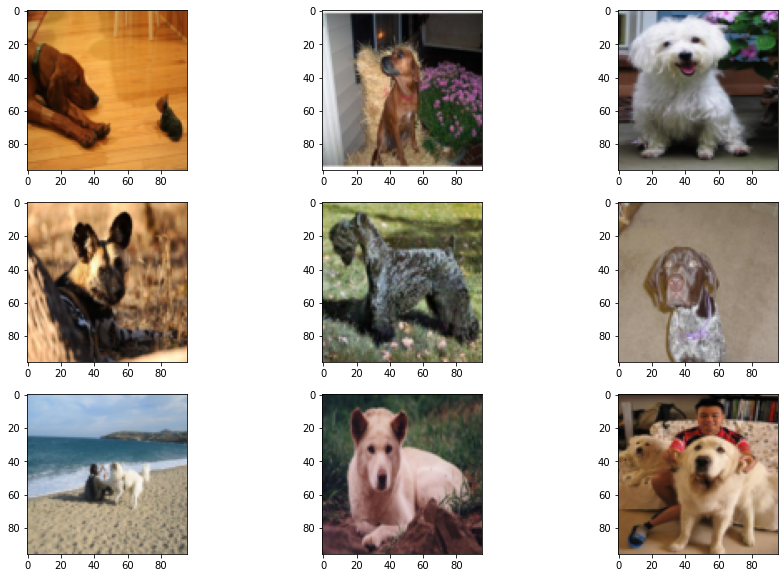

In [12]:
plot_from_batch_generator(train_batch_gen)

In [17]:
class Runner():
    def __init__(self, model, opt, device, checkpoint_name=None):
        self.model = model
        self.opt = opt
        self.device = device
        if checkpoint_name != None:
            self.checkpoint_name = checkpoint_name

        self.epoch = 0
        self.output = None
        self.metrics = None
        self._global_step = 0 #what is it?
        self._set_events() #what is it?
        self._top_val_accuracy = -1
        self.log_dict = {
            "train": [],
            "val": [],
            "test": []
        }
    
    def _set_events(self):
        self._phase_name = ''
        self.events = {
            "train": defaultdict(list),
            "val": defaultdict(list),
            "test": defaultdict(list)
        }
    
    def _reset_events(self, event_name):
        self.events[event_name] = defaultdict(list)

    def forward(self, img_batch, **kwargs):
        logits = self.model(img_batch)
        output = {
            "logits": logits,
        }
        return output
    
    def run_criterion(self, batch):
        raise NotImplementedError("To be implemented")
    
    def output_log(self):
        raise NotImplementedError("To be implemented")
    
    def _run_batch(self, batch):
        # split batch tuple into data batch and label batch
        X_batch, y_batch = batch

        # update the global step in iterations over source data
        self._global_step += len(y_batch)
        
        # move data to target device
        X_batch = X_batch.to(device)
        
        # run the batch through the model
        self.output = self.forward(X_batch)
    
    def _run_epoch(self, loader, train_phase=True, output_log=False, **kwargs):
        # Train phase
        # enable or disable dropout / batch_norm training behavior
        self.model.train(train_phase)

        _phase_description = 'Training' if train_phase else 'Evalution'
        for batch in tqdm(loader, desc=_phase_description, leave=False):
            # forward pass through the model using preset device
            self._run_batch(batch)

            #train on batch compute 
            with torch.set_grad_enabled(train_phase):
                loss = self.run_criterion(batch)
            
            #compute backward pass if training phase
            if train_phase:
                loss.backward()
                self.opt.step()
                self.opt.zero_grad()
            
        self.log_dict[self._phase_name].append(np.mean(self.events[self._phase_name]['loss']))

        if output_log:
            self.output_log(**kwargs)
        
    def train(self, train_loader, val_loader=None, n_epochs=0, model=None, opt=None, **kwargs):
        self.opt = (opt or self.opt)
        self.model = (model or self.model)

        for _epoch in range(n_epochs):
            start_time = time.time()
            self.epoch += 1
            print(f"epoch {self.epoch:3d} / {n_epochs:3d} started")

            #training part
            self._set_events()
            self._phase_name = 'train'
            self._run_epoch(train_loader, train_phase=True)

            print(f"epoch {self.epoch:3d}/{n_epochs:3d} took {time.time() - start_time:.2f}s")

            #validation part
            #here should be validation part, but i don't want divide my dataset
    """
            self._phase_name = 'val'
            self.validate(val_loader, **kwargs)
            self.save_checkpoint()
    """
    @torch.no_grad() # we do not need to save gradients during validation
    def validate(self, loader, model=None, phase_name='val', **kwargs):
        self._phase_name = phase_name
        self._reset_events(phase_name)
        self._run_epoch(loader, train_phase=False, output_log=True, **kwargs)
        return self.metrics
    

In [18]:
#need to define function run_criterion and output_log
class CNNRunner(Runner):
    def run_criterion(self, batch):
        criterion = nn.CrossEntropyLoss()
        X_batch, label_batch = batch
        label_batch = label_batch.to(device)

        logit_batch = self.output['logits']

        #compute loss function
        loss = criterion(logit_batch, label_batch)
        
        scores = F.softmax(logit_batch, 1).detach().cpu().numpy()[:, 1].tolist()
        labels = label_batch.detach().cpu().numpy().ravel().tolist()

        #log some info
        self.events[self._phase_name]['loss'].append(loss.detach().cpu().numpy())
        self.events[self._phase_name]['scores'].extend(scores)
        self.events[self._phase_name]['labels'].extend(labels)

        return loss
    
    def save_checkpoint(self):
        pass

    def output_log(self, **kwargs):
        accuracy = Accuracy(task='multiclass',
                                 num_classes=NUM_CLASSES)
        f1 = F1Score(task='multiclass',
                          num_classes=NUM_CLASSES)
        scores = np.array(self.events[self._phase_name]['scores'])
        labels = np.array(self.events[self._phase_name]['labels'])
        
        assert len(labels) > 0, print('Label list is empty')
        assert len(scores) > 0, print('Score list is empty')
        assert len(labels) == len(scores), print('Label and score lists are of different size')

        visualize = kwargs.get('visualize', False)
        if visualize:
            clear_output()
        
        self.metrics = {
            "loss": np.mean(self.events[self._phase_name]['loss']),
            "accuracy": accuracy(labels, np.int32(scores > 0.5)),
            "f1": f1(labels, np.int32(scores > 0.5))
        }
        print(f'{self._phase_name}: ', end='')
        print(' | '.join([f'{k}: {v:.4f}' for k, v in self.metrics.items()]))

        self.save_checkpoint()

        if visualize:
            if visualize:
                # tensorboard for the poor
                fig = plt.figure(figsize=(15,5))
                ax1 = fig.add_subplot(1,2,1)
                ax2 = fig.add_subplot(1,2,2)
                
                ax1.plot(self.log_dict['train'], color='b', label='train')
                ax1.plot(self.log_dict['val'], color='c', label='val')
                ax1.legend()
                ax1.set_title('Train/val loss.')
                
                class_0_scores = np.array(scores)[np.array(labels) == 0]
                class_1_scores = np.array(scores)[np.array(labels) == 1]
                ax2.hist(class_0_scores, bins=50, range=[0,1.01], color='r', alpha=0.7, label='cats')
                ax2.hist(class_1_scores, bins=50, range=[0,1.01], color='g', alpha=0.7, label='dogs')
                ax2.legend()
                ax2.set_title('Validation set score distribution.')
                
                plt.show()
    


In [19]:
model_cnn = nn.Sequential()


model_cnn.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3))
model_cnn.add_module("pool1", nn.MaxPool2d(2))
model_cnn.add_module("relu1", nn.ReLU())

model_cnn.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3))
model_cnn.add_module("pool2", nn.MaxPool2d(2))
model_cnn.add_module("relu2", nn.ReLU())

model_cnn.add_module("conv3", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3))
model_cnn.add_module("pool3", nn.MaxPool2d(2))
model_cnn.add_module("relu3", nn.ReLU())

model_cnn.add_module("conv4", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3))
model_cnn.add_module("pool4", nn.MaxPool2d(2))
model_cnn.add_module("relu4", nn.ReLU())


# global average pooling
model_cnn.add_module('global_max_pooling', nn.AdaptiveMaxPool2d(1))
# dropout for regularization
model_cnn.add_module('dropout', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', nn.Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False))

In [20]:
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
opt.zero_grad()
model_cnn.to(device)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu4): ReLU()
  (global_max_pooling): AdaptiveMaxPool2d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (dropout_6): Dropout(p=0.3, inplace=False)
  (fc_logits): Linear(in_features=128, out_features=50, bias=F

In [21]:
summary(model_cnn, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             896
         MaxPool2d-2           [-1, 32, 47, 47]               0
              ReLU-3           [-1, 32, 47, 47]               0
            Conv2d-4           [-1, 32, 45, 45]           9,248
         MaxPool2d-5           [-1, 32, 22, 22]               0
              ReLU-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 64, 20, 20]          18,496
         MaxPool2d-8           [-1, 64, 10, 10]               0
              ReLU-9           [-1, 64, 10, 10]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
        MaxPool2d-11            [-1, 128, 4, 4]               0
             ReLU-12            [-1, 128, 4, 4]               0
AdaptiveMaxPool2d-13            [-1, 128, 1, 1]               0
          Dropout-14            [-1, 12

In [22]:
runner = CNNRunner(model_cnn, opt, device)

In [24]:
runner.train(train_batch_gen, n_epochs=10, visualize=False)

epoch   3 /  10 started


epoch   3/ 10 took 57.59s
epoch   4 /  10 started


epoch   4/ 10 took 59.07s
epoch   5 /  10 started


epoch   5/ 10 took 57.28s
epoch   6 /  10 started


epoch   6/ 10 took 56.71s
epoch   7 /  10 started


epoch   7/ 10 took 57.20s
epoch   8 /  10 started


epoch   8/ 10 took 58.74s
epoch   9 /  10 started


epoch   9/ 10 took 59.13s
epoch  10 /  10 started


epoch  10/ 10 took 55.91s
epoch  11 /  10 started


epoch  11/ 10 took 66.45s
epoch  12 /  10 started


epoch  12/ 10 took 57.73s


In [ ]:
from IPython.display import clear_output
from random import sample

epochs = 10
accuracy = Accuracy(task='multiclass',
                    num_classes=NUM_CLASSES)
model = model_cnn
optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
history = []
train_loss_epoch = []
test_loss_epoch = []
train_acccuracy_epoch = []
test_accuracy_epoch = []

for epoch in range(epochs):
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    model.train(True)
    for count, (X_batch, y_batch) in enumerate(train_batch_gen):

        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        #remember history
        train_loss.append(loss.detach().numpy())
        train_accuracy.append(accuracy(preds, y_batch).detach().numpy())
    
    model.eval()
    with torch.no_grad():
        for count, (X_batch, y_batch) in enumerate(val_batch_gen):
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            test_accuracy.append(accuracy(preds, y_batch))
            test_loss.append(loss.detach().numpy())
    train_loss_epoch.append(train_loss)
    test_loss_epoch.append(test_loss)
    train_acccuracy_epoch.append(train_accuracy)
    test_accuracy_epoch.append(test_accuracy)

NameError: name 'Accuracy' is not defined

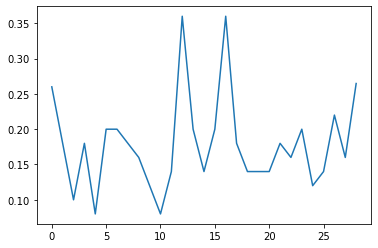

In [25]:
plt.plot(test_accuracy_epoch[9])

### Use Pre-Trained model

In [25]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score

In [26]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)
for p in model_resnet18.parameters():
      p.requires_grad_(False)

num_feat = model_resnet18.fc.in_features
#model_resnet18.fc = nn.Linear(num_feat, 50)

model_resnet18.fc = nn.Sequential(
    nn.Linear(num_feat, 250),
    nn.ReLU(),
    nn.Linear(250, 100),
    nn.ReLU(),
    nn.Linear(100, 50),   
    )

for p in model_resnet18.layer4.parameters():
      p.requires_grad_(True)

for p in model_resnet18.fc.parameters():
      p.requires_grad_(True)

c:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
model_resnet18 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
from torchsummary import summary

summary(model_resnet18, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [29]:
opt = torch.optim.Adam(model_resnet18.parameters(), lr=1e-4)
error = nn.CrossEntropyLoss()

In [30]:
train_loss = []
val_accuracy = []

best_model = None
top_val_accuracy = 0
n_epochs = 5

for epoch in range(n_epochs):
    model_resnet18.train(True)
    for (X_batch, y_batch) in tqdm(train_batch_gen):
        
        outputs = model_resnet18(X_batch)
        loss = error(outputs, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss)
        #clear_output(True)
        #plt.figure(figsize=(8, 6))
        #plt.ylabel("loss")
        #plt.plot(train_loss, label = 'loss_train')
        #plt.legend()
        #plt.grid(True)
        #plt.show()

    model_resnet18.eval()
    for X_batch, y_batch in tqdm(val_batch_gen):
        outputs2 = model_resnet18(X_batch)
        y_pred = outputs2.max(1)[1].data
        val_accuracy.append(accuracy_score(y_batch,y_pred))


100%|██████████| 29/29 [00:15<00:00,  1.93it/s]


In [31]:
a = np.asarray(list(map(np.asarray, val_accuracy)))

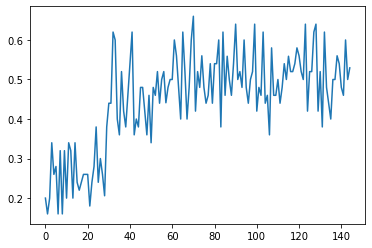

In [32]:
plt.plot(a)

In [33]:
from sklearn.metrics import accuracy_score

val_accuracy = []
model_resnet18.train(False)
for X_batch, y_batch in tqdm(val_batch_gen):
    outputs2 = model_resnet18(X_batch)
    y_pred = outputs2.max(1)[1].data
    val_accuracy.append(accuracy_score(y_batch,y_pred))

100%|██████████| 29/29 [00:14<00:00,  1.97it/s]


In [34]:
print("Accuracy: {} % ".format(round(np.mean(val_accuracy)*100)))

Accuracy: 52 % 


In [35]:
print("Accuracy: {} % ".format(round(np.mean(val_accuracy)*100)))

Accuracy: 52 % 
